# Using Seisbench Pytorch Phasenet model without using *annotate*

This note book shows how to use the pytorch neural network model that is at the heart of the Seisbench implementation of Phasenet.

Using the `annotate` function from the model will break long traces into multiple chuncks and run phasnet on each chunk independently. However, the underlying phasenet model built in pytorch can operate on arbitrary-length traces and is much faster.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seisbench.models as sbm
import torch

from obspy.clients.fdsn import Client
from obspy import UTCDateTime

Load phasenet model with original parameters

In [2]:
pnmodel = sbm.PhaseNet.from_pretrained("original")

Download sample seismic data

In [3]:
client = Client("GFZ")

t = UTCDateTime("2007/01/02 05:48:50")
stream = client.get_waveforms(
    network="CX",
    station="PB01",
    location="*",
    channel="HH?",
    starttime=t-5,
    endtime=t+72
).normalize()

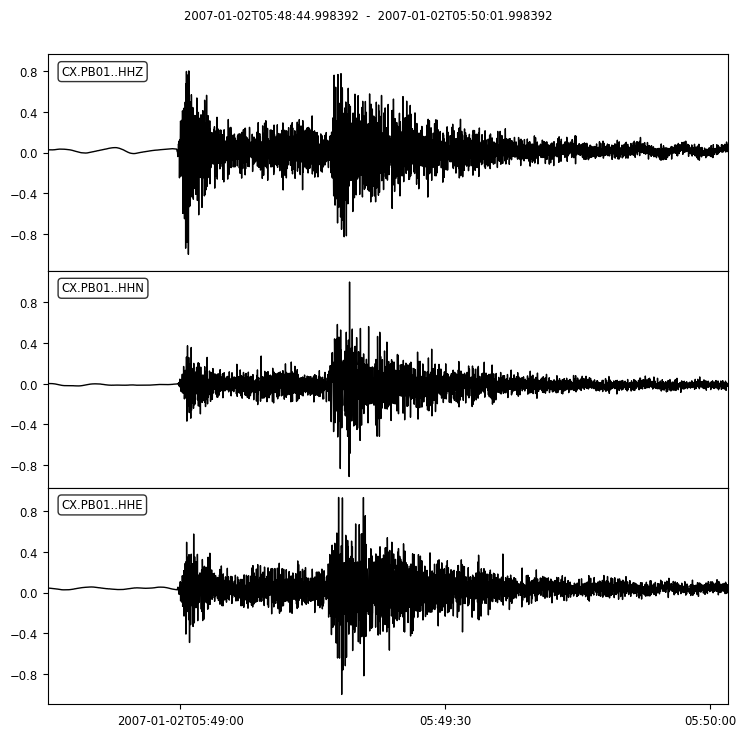

In [4]:
stream.plot();

The following code converts the obspy stream we just downloaded into a Pytorch tensor for feeding into the model. Note that for this model the tensor must be cast to `float`, otherwise it will throw an error. Also note that the `unsqueeze` function adds a dimension to the front of the tensor. This is the batch dimension, and in our case is 1 since we have only one sample.

In [5]:
X = np.stack([x.data for x in stream])
X_ = torch.tensor(X).unsqueeze(dim=0).float()
X_.shape

torch.Size([1, 3, 7701])

Run the model and remove the batch dimension for plotting later.

In [6]:
out = pnmodel(X_).squeeze()

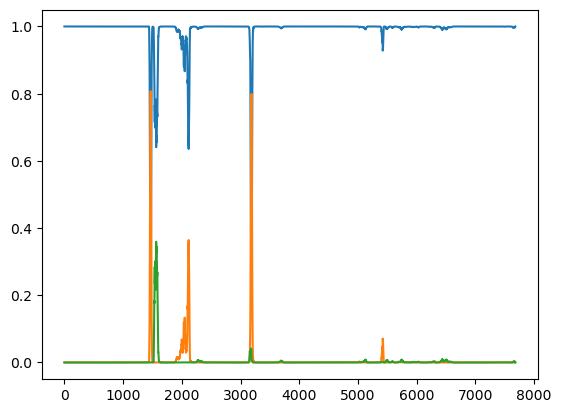

In [7]:
for a in out.detach().numpy():
    plt.plot(a)

How fast is this version compared with using the `annotate` function?

In [8]:
%timeit _ = pnmodel.annotate(stream)

10.2 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
%timeit _ = pnmodel(X_)

7.17 ms ± 100 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


30% faster for a 7701 sample, 3-component seismogram. What about a bigger one?

In [11]:
stream2 = client.get_waveforms(
    network="CX",
    station="PB01",
    location="*",
    channel="HH?",
    starttime=t-5,
    endtime=t+720
).normalize()

Y = np.stack([x.data for x in stream2])
Y_ = torch.tensor(Y).unsqueeze(dim=0).float()
Y_.shape

torch.Size([1, 3, 72501])

In [12]:
%timeit _ = pnmodel.annotate(stream2)

451 ms ± 7.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit _ = pnmodel(Y_)

22.3 ms ± 415 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


20x faster for a 72,501 sample 3-cpt seismogram!

How about larger batches?

Let's stack the same tensor 10x and run with plain pytorch.

In [17]:
Z = Y_.repeat(10,1,1)
Z.shape

torch.Size([10, 3, 72501])

In [18]:
%timeit _ = pnmodel(Z)

125 ms ± 6.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Interestingly, it's only 5x slower than a batch of 1. Perhaps it's taking advantage of the Mac M1 GPU shaders.